In [1]:
from anything_vae import (
    Encoder,
    Decoder,
)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, models as torchvision_models
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
# import pytorch_lightning as pl
from torchmetrics import MeanSquaredError
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

from collections import deque
import heapq

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        self.tranform_output = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return 1000
        # return len(self.images)/

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.tranform_output(self.__loadImage(colored))
        return sketch_image, colored_image

    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))


In [3]:
class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval()
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.scale = (dim // heads) ** -0.5

        self.to_qkv = nn.Conv2d(dim, dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: t.reshape(b, self.heads, -1, h * w), qkv)

        dots = torch.matmul(q.transpose(-2, -1), k) * self.scale
        attn = dots.softmax(dim=-1)

        out = torch.matmul(attn, v.transpose(-2, -1))
        out = out.reshape(b, -1, h, w)
        return self.to_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.attention = SelfAttention(dim, heads)
        # Change normalization to handle spatial dimensions
        self.norm1 = nn.GroupNorm(8, dim)  # Using GroupNorm instead of LayerNorm
        self.norm2 = nn.GroupNorm(8, dim)
        self.ffn = nn.Sequential(
            nn.Conv2d(dim, dim * 4, 1),
            nn.GELU(),
            nn.Conv2d(dim * 4, dim, 1)
        )

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x

class Colorizer(LightningModule):
    def __init__(self, checkpoint_path=None, transformer_dim=256, transformer_heads=8):
        super(Colorizer, self).__init__()
        if checkpoint_path is not None:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            
            self.encoder = Encoder()
            self.decoder = Decoder()
            self.quant_conv = nn.Conv2d(8, 8, kernel_size=1)
            self.post_quant_conv = nn.Conv2d(4, 4, kernel_size=1)
            
            self.encoder.load_state_dict(
                {k.replace('encoder.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('encoder.')}
            )
            self.decoder.load_state_dict(
                {k.replace('decoder.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('decoder.')}
            )
            self.quant_conv.load_state_dict(
                {k.replace('quant_conv.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('quant_conv.')}
            )
            self.post_quant_conv.load_state_dict(
                {k.replace('post_quant_conv.', ''): v for k, v in checkpoint['state_dict'].items() if k.startswith('post_quant_conv.')}
            )
            
            vgg_model = vgg16(weights=True)
            self.loss_fn = VGGPerceptualLoss(vgg_model)
            self.mse_loss_fn = nn.MSELoss()
            
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False
            for param in self.quant_conv.parameters():
                param.requires_grad = False
            for param in self.post_quant_conv.parameters():
                param.requires_grad = False
                
            print("Loaded pretrained weights from checkpoint")
        else:
            # Initialize new components
            self.encoder = Encoder()
            self.decoder = Decoder()
            self.quant_conv = nn.Conv2d(8, 8, kernel_size=1)
            self.post_quant_conv = nn.Conv2d(4, 4, kernel_size=1)
            vgg_model = vgg16(weights=True)
            self.loss_fn = VGGPerceptualLoss(vgg_model)
            self.mse_loss_fn = nn.MSELoss()
            print("Initialized new model from scratch")

            
        # Add transformer layers (always initialized from scratch)
        self.to_transformer_dim = nn.Conv2d(4, transformer_dim, 1)
        self.transformer = TransformerBlock(transformer_dim, transformer_heads)
        self.from_transformer_dim = nn.Conv2d(transformer_dim, 4, 1)
        self.num_high_loss_images = 50
        self.high_loss_heap = []  # Min heap to track top N highest loss images
        self.current_min_high_loss = 0  # Current minimum loss in our high loss collection
        
        self.hparams.learning_rate = 0.0001

    def encode(self, x):
        h = self.encoder(x)
        h = self.quant_conv(h)
        mean, logvar = torch.chunk(h, 2, dim=1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + std * eps
        return z

    def decode(self, z):
        # Apply transformer before decoding
        z = self.post_quant_conv(z)
        z = self.to_transformer_dim(z)
        z = self.transformer(z)
        z = self.from_transformer_dim(z)
        x_recon = self.decoder(z)
        return x_recon

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon

    def configure_optimizers(self):
        return torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()), 
            lr=self.hparams.learning_rate
        )

    def store_high_loss_image(self, loss, inputs, targets, outputs):
        """
        Store high loss images efficiently using a min heap to maintain top N
        All tensors are stored in CPU memory
        """
        # Convert to CPU and detach from computation graph
        cpu_data = {
            'loss': loss.item(),
            'inputs': inputs.detach().cpu(),
            'targets': targets.detach().cpu(),
            'outputs': outputs.detach().cpu()
        }
        
        if len(self.high_loss_heap) < self.num_high_loss_images:
            # Heap not full yet, add new entry
            heapq.heappush(self.high_loss_heap, (loss.item(), cpu_data))
            self.current_min_high_loss = min(loss.item(), self.current_min_high_loss if self.high_loss_heap else float('inf'))
        elif loss.item() > self.current_min_high_loss:
            # Remove lowest loss entry and add new higher loss entry
            heapq.heapreplace(self.high_loss_heap, (loss.item(), cpu_data))
            self.current_min_high_loss = self.high_loss_heap[0][0]


    def visualize_model_output(self, inputs, outputs, targets, logger, step, tag):
        """Helper function to create and log visualization grid with horizontal layout"""
        inputs = inputs.detach().cpu()
        outputs = outputs.detach().cpu()
        targets = targets.detach().cpu()
        
        n = inputs.shape[0]
        
        grid = []
        for i in range(n):
            row = torch.stack([inputs[i], outputs[i], targets[i]])
            grid.append(row)
        
        grid = torch.cat(grid, dim=0)
        
        if grid.shape[1] == 1:
            grid = grid.repeat(1, 3, 1, 1)
        
        grid = torchvision.utils.make_grid(grid, nrow=3, normalize=True, padding=2)
        
        logger.experiment.add_image(tag, grid, step)

    def visualize_single_output(self, input_img, output_img, target_img):
        """Helper function to create a single row grid for one set of images"""
        # Ensure we're working with batched images
        if input_img.dim() == 3:
            input_img = input_img.unsqueeze(0)
            output_img = output_img.unsqueeze(0)
            target_img = target_img.unsqueeze(0)
            
        # Create row with input, output, and target
        row = torch.cat([input_img, output_img, target_img], dim=0)
        
        # Handle grayscale images
        if row.shape[1] == 1:
            row = row.repeat(1, 3, 1, 1)
            
        # Create grid with the three images side by side
        grid = torchvision.utils.make_grid(row, nrow=3, normalize=True, padding=2)
        return grid

    def visualize_high_loss_images(self, logger, step):
        """Visualize stored high loss images individually"""
        if not self.high_loss_heap:
            return
            
        # Sort by loss in descending order
        sorted_entries = sorted(self.high_loss_heap, key=lambda x: x[0], reverse=True)
        
        # Log each high-loss image separately
        for idx, (loss_value, data) in enumerate(sorted_entries):
            grid = self.visualize_single_output(
                data['inputs'],
                data['outputs'],
                data['targets']
            )

            logger.experiment.add_image('High_Loss_Images', grid, step)
                    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
    
        perceptual_loss = self.loss_fn(outputs, targets)
        mse_loss = self.mse_loss_fn(outputs, targets)
        total_loss = perceptual_loss + mse_loss
        
        # Basic loss logging
        self.log('train_loss', total_loss)
        self.log('perceptual_loss', perceptual_loss)
        self.log('mse_loss', mse_loss)
        
        # Store high loss images
        self.store_high_loss_image(total_loss, inputs, targets, outputs)
        
        # Every 100 batches, visualize the current high loss images
        if (batch_idx + 1) % 100 == 0:
            self.visualize_high_loss_images(self.logger, self.global_step)
        
        # Log sample images every 500 batches
        if batch_idx % 500 == 0:
            num_images = min(4, inputs.shape[0])
            for i in range(num_images):
                grid = self.visualize_single_output(
                    inputs[i],
                    outputs[i],
                    targets[i]
                )
                logger.experiment.add_image(
                    f'Sample_Images/sample_{i+1}',
                    grid,
                    self.global_step
                )
        
        return total_loss


In [5]:
chkpt_file = 'checkpoints/version_13.ckpt'
model = Colorizer(checkpoint_path=chkpt_file)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded pretrained weights from checkpoint


In [6]:
# pretrained_model = torch.load('anything-vae.pth', map_location='cpu')
# model = Colorizer()
# pretrained_state_dict = pretrained_model.state_dict()
# missing_keys, unexpected_keys = model.load_state_dict(pretrained_state_dict, strict=False)
# filtered_missing_keys = [key for key in missing_keys if not key.startswith('loss_fn')]
# assert len(filtered_missing_keys) == 0
# assert len(unexpected_keys) == 0

In [7]:
data_folder = 'data/toy'
# data_folder = 'data/training'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)
dataloader = DataLoader(training_dataset, batch_size=1, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
logger = loggers.TensorBoardLogger("tb_logs", name='frozen-pretrained-vae-with-new-transformer')
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=20, logger=logger, log_every_n_steps=2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type              | Params
-----------------------------------------------------------
0 | encoder              | Encoder           | 34.2 M
1 | decoder              | Decoder           | 49.5 M
2 | quant_conv           | Conv2d            | 72    
3 | post_quant_conv      | Conv2d            | 20    
4 | loss_fn              | VGGPerceptualLoss | 138 M 
5 | mse_loss_fn          | MSELoss           | 0     
6 | to_transformer_dim   | Conv2d            | 1.3 K 
7 | transformer          | TransformerBlock  | 788 K 
8 | from_transformer_dim | Conv2d            | 1.0 K 
-----------------------------------------------------------
137 M     Trainable params
85.4 M    Non-trainable params
222 M     Total params
891.211   Total estimated model params size (MB)


Epoch 9:  30%|██▉       | 296/1000 [02:37<06:13,  1.88it/s, v_num=16] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 16:  62%|██████▏   | 616/1000 [06:11<03:51,  1.66it/s, v_num=16] 

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [10]:
# trainer = Trainer(model, training_dataset, device)
# trainer.train()

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def viewTensor(output):
    image = to_pil_image(output.squeeze())

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

In [12]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)
model.cpu()

Colorizer(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
  

In [13]:
idx = 10
x, y = test_dataset[idx]
output = model(x.unsqueeze(0))

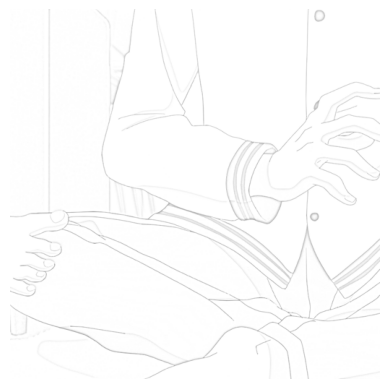

In [14]:
viewTensor(x)

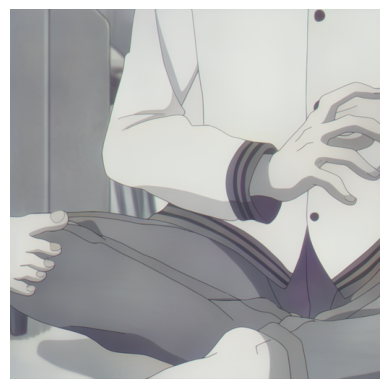

In [15]:
viewTensor(output[0])

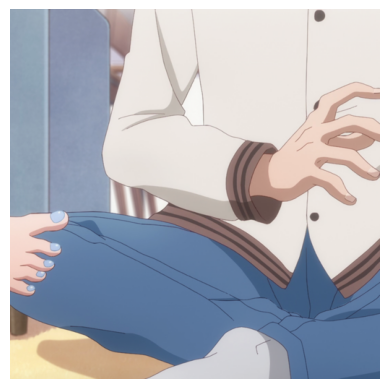

In [16]:
viewTensor(y)